In [1]:
# Bibliotecas Utilizadas no Pre Processamento
import pandas as pd
import numpy as np
import matplotlib.pyplot as ply
import seaborn as sns
import mmh3
import random
%matplotlib inline

In [2]:
%%capture
from tqdm import notebook as nb_tqdm
nb_tqdm.tqdm().pandas()

In [3]:
# Importanto dados utilizados
messages = pd.read_csv('databases/private-data/messages.csv')
orders = pd.read_csv('databases/private-data/order.csv')
sensors = pd.read_csv('databases/private-data/sensors.csv')

# Fetching public data
public = pd.read_csv('databases/public.csv')

### Restringindo as tabelas Mensagens e Sensores para o Voos com Label

In [4]:
# Escolhendo voos
public_reduced = public.copy() # Trocar por public.head(NUM_VOOS).copy() se for testar com menos voos

# Armazenando os voos que serão previstos
flights = set(public_reduced['FLIGHT'].unique())

In [5]:
# Reduzindo sensors e messages para somente os voos estudados
sensors_reduced = sensors[sensors['FLIGHT'].isin(flights)].copy()
messages_reduced = messages[messages['FLIGHT'].isin(flights)].copy()

# Tirando as duplicatas
sensors_reduced.drop_duplicates(inplace=True)
messages_reduced.drop_duplicates(inplace=True)

In [6]:
# Função para limitar o número de linhas por voo
def limitNumberOfRowsPerFlight(df,flight_col_name,limit_rows):
    # Criando um data frame auxiliar com as mesmas colunas do original
    reduced_df = pd.DataFrame(columns = list(df.columns))
    
    # Setando limite de linhas por VOO
    LIMIT_ROWS_PER_FLIGHT = limit_rows
    
    # Unique Flights in DF
    unique_flights = list(df[flight_col_name].unique())
    
    # Montando a tabela iterando em cada um dos voos únicos
    for uf in nb_tqdm.tqdm(unique_flights): 
        # Armazenando em quais indices do DF original estão os registros desse voo                
        indices = list(df[df[flight_col_name] == uf].index)            

        # Verificando se o número de Voos é maior que o limite. Se for, faz-se a redução
        if len(indices) > LIMIT_ROWS_PER_FLIGHT:
            # Escolhendo indices aleatórios
            random.seed(4)
            limited_indices = random.sample(indices,LIMIT_ROWS_PER_FLIGHT)
        else:
            limited_indices = indices
            
        limited_indices.sort() # Garantindo ordem crescente dos índices

        # Preenchendo o novo DataFrame
        reduced_df = reduced_df.append(df[df.index.isin(limited_indices)],ignore_index=True)
            
    return reduced_df

In [7]:
# Limitando o número de Linhas por Voo nas tabelas
sensors_reduced = limitNumberOfRowsPerFlight(sensors_reduced,'FLIGHT',200)
messages_reduced = limitNumberOfRowsPerFlight(messages_reduced,'FLIGHT',200)

In [8]:
# Checando o tamanho da tabela sensors
sensors_reduced

,AC,FLIGHT,TIME,AMBIENT_1,PAR_AC_1,PAR_AC_2,PAR_AC_3,PAR_AC_4,PAR_SYS_1,PAR_SYS_2,...,WAR_SYS_1,COM_SYS_1,PAR_SYS_9,PAR_SYS_10,PAR_SYS_5,WAR_SYS_2,PAR_SYS_6,WAR_SYS_3,PAR_SYS_7,PAR_SYS_8
0,AC19,006042,3115,11723.0,0.00000,29.11250,0,0,65.375,247.0,...,0,0,0.0,0.0,0.0,0,0,0,0.000,16.2000
1,AC19,006042,3132,11721.0,0.00000,29.28375,0,0,65.375,299.0,...,0,0,0.0,0.0,0.0,0,0,0,0.000,0.0000
2,AC19,006042,3204,11721.0,29.28375,29.45500,0,0,44.250,279.0,...,0,0,0.0,0.0,1.0,0,1,0,99.225,111.0375
3,AC19,006042,3218,11721.5,29.45500,29.62625,0,0,43.875,230.0,...,0,0,0.0,0.0,1.0,0,1,0,112.725,121.1625
4,AC19,006042,3266,11721.0,29.28375,29.62625,0,0,42.875,265.0,...,0,0,0.0,0.0,1.0,0,1,0,129.600,123.1875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180195,AC36,fe38f6,5689,12230.0,30.65375,13.87125,0,0,44.375,245.0,...,0,0,0.0,0.0,1.0,0,1,0,98.550,44.5500
180196,AC36,fe38f6,5699,12230.5,0.00000,0.00000,0,0,22.250,234.0,...,0,0,0.0,0.0,0.0,0,0,0,0.000,0.0000
180197,AC36,fe38f6,5719,12231.5,10.44625,0.00000,0,0,22.375,235.0,...,0,0,0.0,0.0,0.0,0,0,0,0.000,0.0000
180198,AC36,fe38f6,5736,12234.0,0.00000,0.00000,0,0,22.250,234.0,...,0,0,0.0,0.0,0.0,0,0,0,0.000,0.0000


In [9]:
# Checando o tamanho da tabela mensages
messages_reduced

,AC,FLIGHT,TIME,FLIGHT_PHASE,TYPE,MESSAGE
0,AC19,03896c,105,2,FDE,120
1,AC19,03896c,4890,3,FDE,120
2,AC19,03d505,3454,2,FDE,120
3,AC19,03d505,6048,3,FDE,120
4,AC19,03d505,8307,2,FDE,120
...,...,...,...,...,...,...
2677,AC30,08d31a,-2077049,4,MM,4713
2678,AC30,08d31a,-1826741,7,MM,4755
2679,AC30,08d31a,-1751362,4,MM,4713
2680,AC30,08d31a,-1728715,2,MM,4713


In [10]:
# Vendo as features de sensors
sensors_reduced.describe()

,AMBIENT_1,PAR_AC_1,PAR_AC_2,PAR_SYS_1,PAR_SYS_2,PAR_SYS_3,PAR_SYS_9,PAR_SYS_10,PAR_SYS_5,PAR_SYS_7,PAR_SYS_8
count,180200.000000,180200.000000,180200.000000,180200.000000,180200.000000,180200.000000,180200.000000,180200.000000,180200.000000,180200.000000,180200.000000
mean,34059.760205,90.771504,90.466276,55.980257,311.473479,55.585711,2.036479,2.025380,0.927037,110.306245,109.510103
std,15018.572486,38.473034,39.011476,7.340264,26.612642,7.652851,2.417872,2.406049,0.260077,33.040672,31.136798
min,5856.000000,0.000000,0.000000,20.000000,141.000000,-119.875000,0.000000,-0.375000,0.000000,0.000000,0.000000
25%,17680.000000,54.286250,54.286250,54.000000,307.000000,53.875000,0.000000,0.000000,1.000000,92.812500,92.812500
50%,39221.000000,115.422500,115.422500,55.250000,320.000000,55.250000,0.000000,0.000000,1.000000,101.925000,101.250000
75%,48036.500000,119.532500,119.532500,60.000000,326.000000,59.375000,3.675000,3.675000,1.000000,136.350000,132.975000
max,53009.500000,129.465000,129.293750,125.250000,370.000000,155.125000,7.500000,7.275000,1.000000,384.750000,392.512500


In [11]:
# Retirando as colunas nulas
drop_columns = ['WAR_SYS_1','COM_SYS_1','WAR_SYS_2','WAR_SYS_3']
sensors_reduced.drop(drop_columns,axis=1,inplace=True)

# Retirando outras colunas (baixa variância) em relação  a média
other_columns = ['PAR_AC_3','PAR_AC_4','PAR_SYS_5','PAR_SYS_6']
sensors_reduced.drop(other_columns,axis=1,inplace=True)

In [12]:
# Escolhendo 6 features
sensors_reduced = sensors_reduced[['AC','FLIGHT','TIME','AMBIENT_1','PAR_SYS_1','PAR_SYS_9']]

In [13]:
# Vendo as features de messages
messages_reduced.describe()

,AC,FLIGHT,TIME,FLIGHT_PHASE,TYPE,MESSAGE
count,2682,2682,2682,2682,2682,2682
unique,5,391,2574,7,2,22
top,AC23,bcb197,159,2,FDE,120
freq,1149,200,3,1655,2234,2149


### Removendo outliers numéricos de cada uma das features através da análise de histogramas

#### Tabela Sensors Reduced

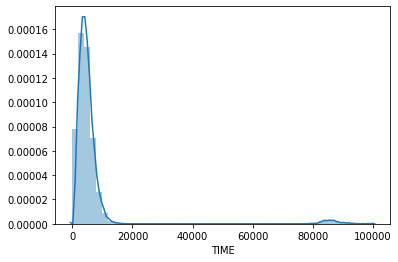

In [14]:
# TIME
sns.distplot(sensors_reduced['TIME'])

Calda longa! Precisa remover outliers

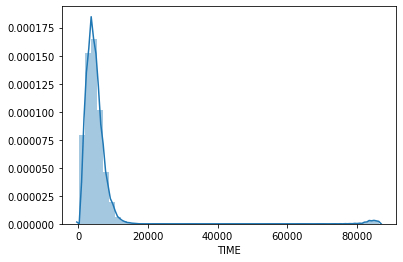

In [15]:
# Removendo os outliers
lowerbound,upperbound = np.percentile(sensors_reduced['TIME'],[1,99])
sensors_reduced = sensors_reduced.query('{} <= TIME <= {}'.format(lowerbound,upperbound))

# Nova Distribuição para TIME
sns.distplot(sensors_reduced['TIME'])

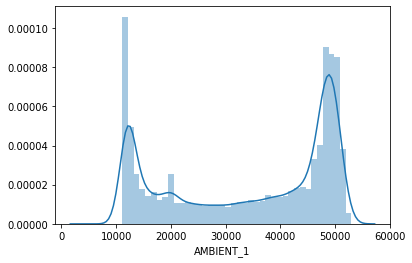

In [16]:
# AMBIENT_1
sns.distplot(sensors_reduced['AMBIENT_1'])

Não precisa remover outliers

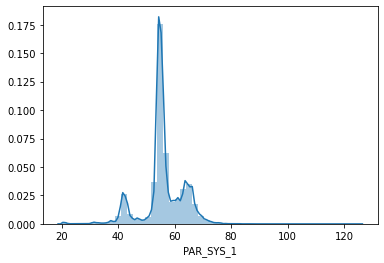

In [17]:
# PAR_SYS_1
sns.distplot(sensors_reduced['PAR_SYS_1'])

Caldas longas em ambos os lados. Haverá remoção de outliers!

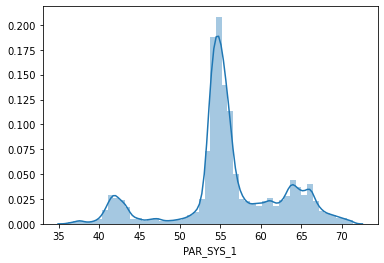

In [18]:
# Removendo os outliers
lowerbound,upperbound = np.percentile(sensors_reduced['PAR_SYS_1'],[1,99])
sensors_reduced = sensors_reduced.query('{} <= PAR_SYS_1 <= {}'.format(lowerbound,upperbound))

# Nova Distribuição para PAR_SYS_1
sns.distplot(sensors_reduced['PAR_SYS_1'])

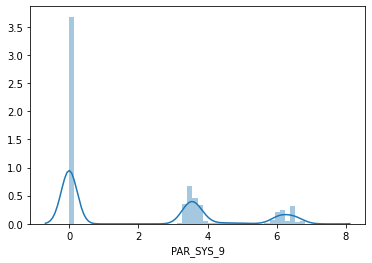

In [19]:
# PAR_SYS_9
sns.distplot(sensors_reduced['PAR_SYS_9'])

Não há outliers

In [20]:
# Guardando a tabela sensors_reduced sem outliers
wo_sensors_reduced = sensors_reduced.copy()

#### Tabela Messages Reduced

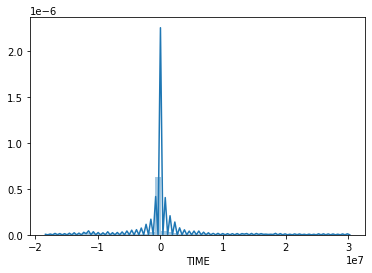

In [21]:
# TIME
sns.distplot(messages_reduced['TIME'])

Sem Outliers!

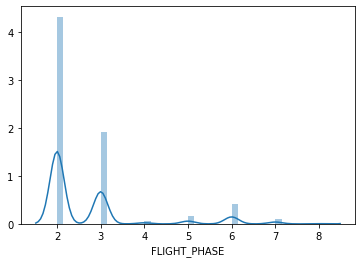

In [22]:
# FLIGHT_PHASE
sns.distplot(messages_reduced['FLIGHT_PHASE'])

Sem outliers!

RuntimeError: Selected KDE bandwidth is 0. Cannot estimate density.

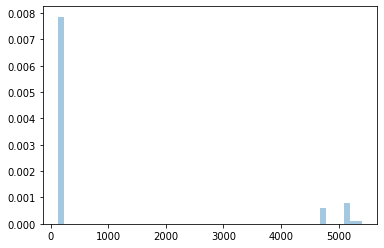

In [23]:
# MESSAGE
sns.distplot(messages_reduced['MESSAGE'])

Sem outliers!

In [24]:
# Guardando a tabela sensors_reduced sem outliers
wo_messages_reduced = messages_reduced.copy()

### Montando a tabela com as features e a target

In [25]:
# Formatando as tabelas para merge
wo_sensors_reduced.set_index('FLIGHT',inplace=True)
wo_messages_reduced.set_index('FLIGHT',inplace=True)

# Merging sensors and messages data
sns_and_msg = wo_sensors_reduced.merge(wo_messages_reduced,left_on="FLIGHT", right_on="FLIGHT",how="left",suffixes=('_sns','_msg')).progress_apply(lambda x: x)
sns_and_msg.drop('AC_msg',axis=1,inplace=True)

# Formatando a tabela public reduced para merge
public_reduced.set_index('FLIGHT',inplace=True)

# Acrescendo a coluna target através de um merge com a tabelas public
model_data = sns_and_msg.merge(public_reduced,left_on="FLIGHT",right_on="FLIGHT",how="left",suffixes=('_sm','_pb')).progress_apply(lambda x: x)

In [26]:
# Ajustando o índice
model_data.reset_index(inplace=True)

In [27]:
# Checando o número de null values após o left join
model_data.isnull().sum()

FLIGHT              0
AC_sns              0
TIME_sns            0
AMBIENT_1           0
PAR_SYS_1           0
PAR_SYS_9           0
TIME_msg        97575
FLIGHT_PHASE    97575
TYPE            97575
MESSAGE         97575
MAINTENANCE         0
dtype: int64

In [28]:
# Preenchendo os valores nulos
model_data['TIME_msg'].fillna(0,inplace=True) # Preenchendo com valor O para o caso dos sensores em que não há mensagem
model_data['FLIGHT_PHASE'].fillna(0,inplace=True) # Preenchendo com valor 0 para o caso dos sensores em que não há mensagem
model_data['TYPE'].fillna('SM',inplace=True) # SM =  Sem Mensagem
model_data['MESSAGE'].fillna(100,inplace=True) # Codigo correspondente ao caso da ausência de messagem

In [29]:
# Colunas
model_data.columns

Index(['FLIGHT', 'AC_sns', 'TIME_sns', 'AMBIENT_1', 'PAR_SYS_1', 'PAR_SYS_9',
       'TIME_msg', 'FLIGHT_PHASE', 'TYPE', 'MESSAGE', 'MAINTENANCE'],
      dtype='object')

In [30]:
# Renomeando as colunas
model_data.columns = ['flight','ac','sensor_time','sensor_ambient',
                      'sensor_par_sys_1','sensor_par_sys_9',
                      'message_time','flight_phase','message_type',
                      'message','target']

In [31]:
model_data['sensor_time'] = model_data['sensor_time'].astype(int)

model_data

,flight,ac,sensor_time,sensor_ambient,sensor_par_sys_1,sensor_par_sys_9,message_time,flight_phase,message_type,message,target
0,006042,AC19,3115,11723.0,65.375,0.0,0,0,SM,100,4
1,006042,AC19,3132,11721.0,65.375,0.0,0,0,SM,100,4
2,006042,AC19,3204,11721.0,44.250,0.0,0,0,SM,100,4
3,006042,AC19,3218,11721.5,43.875,0.0,0,0,SM,100,4
4,006042,AC19,3266,11721.0,42.875,0.0,0,0,SM,100,4
...,...,...,...,...,...,...,...,...,...,...,...
617578,fe38f6,AC36,5538,12225.5,44.375,0.0,0,0,SM,100,10
617579,fe38f6,AC36,5549,12222.0,44.500,0.0,0,0,SM,100,10
617580,fe38f6,AC36,5583,12220.5,44.000,0.0,0,0,SM,100,10
617581,fe38f6,AC36,5592,12222.0,44.125,0.0,0,0,SM,100,10


### Encoding de Variáveis Categóricas

In [32]:
# Filtrando somente os colunas categóricas
num_cols = model_data._get_numeric_data().columns
cat_cols = set(model_data.columns) - set(num_cols) # Armazenando colunas categóricas

In [33]:
# Printando as variáveis categóricas
cat_cols

{'ac', 'flight', 'message_type'}

In [34]:
# Função auxiliar para calcular média suavizada (Target Encoding)
def calc_smooth_mean(df,cat_name,target,weight):
    # Compute the global mean
    mean = df[target].mean()
    
    # Compute the number of values and the mean of each group
    agg = df.groupby(cat_name)[target].agg(['count','mean'])
    counts = agg['count']
    means = agg['mean']
    
    # Compute the smoothed means
    smooth = (counts*means + weight*mean)/(counts+weight)
    
    return df[cat_name].map(smooth)

# Função que substitui a variável categórica pelo seu número de ocorrências
def hash_function(df,cat_name):
    return df[cat_name].progress_apply(lambda x: mmh3.hash(x,seed=42,signed=False))

In [35]:
# Aplicando o encoding
model_data['ac'] = hash_function(model_data,cat_name='ac')
model_data['flight'] = hash_function(model_data,cat_name='flight')
model_data['message_type'] = hash_function(model_data,cat_name='message_type')

### Finalmente após todo o processo de Feature Engineering

In [36]:
model_data

,flight,ac,sensor_time,sensor_ambient,sensor_par_sys_1,sensor_par_sys_9,message_time,flight_phase,message_type,message,target
0,3945526026,3272462994,3115,11723.0,65.375,0.0,0,0,101350308,100,4
1,3945526026,3272462994,3132,11721.0,65.375,0.0,0,0,101350308,100,4
2,3945526026,3272462994,3204,11721.0,44.250,0.0,0,0,101350308,100,4
3,3945526026,3272462994,3218,11721.5,43.875,0.0,0,0,101350308,100,4
4,3945526026,3272462994,3266,11721.0,42.875,0.0,0,0,101350308,100,4
...,...,...,...,...,...,...,...,...,...,...,...
617578,3552854091,1836135844,5538,12225.5,44.375,0.0,0,0,101350308,100,10
617579,3552854091,1836135844,5549,12222.0,44.500,0.0,0,0,101350308,100,10
617580,3552854091,1836135844,5583,12220.5,44.000,0.0,0,0,101350308,100,10
617581,3552854091,1836135844,5592,12222.0,44.125,0.0,0,0,101350308,100,10


## Implementando o modelo XGBoost

In [37]:
# Bibliotecas para rodar o modelo e testar sua eficiência
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [38]:
# Separando as features e a target
X,y = model_data.iloc[:,:-1],model_data.iloc[:,-1]

In [39]:
# Separando Train e Validation sets
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2,random_state=41)

In [40]:
# Instaciando o XGBoost Regressor
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,verbosity=1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [41]:
# Por fim, treinando o modelo
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [42]:
from sklearn.metrics import mean_squared_error
# Testando a acurácia do modelo com a validation data
pred_train = xg_reg.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, pred_train))
print("RMSE: %f" % (rmse))

RMSE: 4.565172


### Previsão dos dados sem Label

In [43]:
# Separando base de dados para teste (com label desconhecido)
public_flights = set(public['FLIGHT'].unique())
sensors_flights = set(sensors['FLIGHT'].unique())

test_flights = sensors_flights - public_flights

#### Preparando o vetor das features para esses dados

In [44]:
# Slicing
sensors_test = sensors[sensors['FLIGHT'].isin(test_flights)].copy()
messages_test = messages[messages['FLIGHT'].isin(test_flights)].copy()

In [45]:
# Tirando as duplicatas
sensors_test.drop_duplicates(inplace=True)
messages_test.drop_duplicates(inplace=True)

In [46]:
# Limitando o número de Linhas por Voo nas tabelas
sensors_test = limitNumberOfRowsPerFlight(sensors_test,'FLIGHT',200)
messages_test = limitNumberOfRowsPerFlight(messages_test,'FLIGHT',200)

In [47]:
# Retirando colunas nulas
drop_columns = ['WAR_SYS_1','COM_SYS_1','WAR_SYS_2','WAR_SYS_3','PAR_AC_3','PAR_AC_4','PAR_SYS_5','PAR_SYS_6']
sensors_test.drop(drop_columns,axis=1,inplace=True)

# Escolhendo somente as colunas importantes
sensors_test = sensors_test[['AC','FLIGHT','TIME','AMBIENT_1','PAR_SYS_1','PAR_SYS_9']]

In [48]:
# Mudança de índices
sensors_test.set_index('FLIGHT',inplace=True)
messages_test.set_index('FLIGHT',inplace=True)

# Mergiando 
x_test = sensors_test.merge(messages_test,left_on="FLIGHT",right_on="FLIGHT",how="left",suffixes=('_sns','_msg')).progress_apply(lambda x: x)
x_test.drop('AC_msg',axis=1,inplace=True)
x_test.reset_index(inplace=True)

In [49]:
# Preenchendo os valores nulos
x_test['TIME_msg'].fillna(0,inplace=True)  
x_test['FLIGHT_PHASE'].fillna(0,inplace=True) 
x_test['TYPE'].fillna('SM',inplace=True) 
x_test['MESSAGE'].fillna(100,inplace=True)

# Renomendo as colunas
x_test.columns = ['flight','ac','sensor_time','sensor_ambient',
                      'sensor_par_sys_1','sensor_par_sys_9',
                      'message_time','flight_phase','message_type',
                      'message']
    
x_test['sensor_time'] = x_test['sensor_time'].astype(int)

In [50]:
# Tratando as variáveis categóricas
num_cols = x_test._get_numeric_data().columns
cat_cols = set(x_test.columns) - set(num_cols)

# Salvando lista de voos, na ordem certa
test_flights_correct_order = x_test['flight']

# Aplicando Hash Function
x_test['ac'] = hash_function(x_test,cat_name='ac')
x_test['flight'] = hash_function(x_test,cat_name='flight')
x_test['message_type'] = hash_function(x_test,cat_name='message_type')

In [51]:
# Prevendo os dados de acorod com o modelo
y = xg_reg.predict(x_test)

In [81]:
# Formatando os dados para a saída prevista pelo Kaggle
data = x_test.copy()
data['target'] = list(y)
data['flight'] = test_flights_correct_order
output = data.groupby('flight')['target'].mean().progress_apply(lambda x:x)

# Ajustando o DF
df = output.reset_index()
df.index = np.arange(1,len(output)+1)
df.columns = ['FLIGHT','MAINTENANCE']

In [95]:
# Exportando a previsão para .CSV
df.to_csv('first_prediction.csv',index=False)

In [55]:
## Pre processamento na forma de Iteração
"""final_predictions = {}
i = 0
for f in nb_tqdm.tqdm(list(test_flights)):
    sns = sensors_test[sensors_test['FLIGHT'] == f]
    msg = messages_test[messages_test['FLIGHT'] == f]
    
    sns.set_index('FLIGHT',inplace=True)
    msg.set_index('FLIGHT',inplace=True)
    
    x_test = sns.merge(msg,left_on="FLIGHT", right_on="FLIGHT",how="left",suffixes=('_sns','_msg'))
    x_test.drop('AC_msg',axis=1,inplace=True)
    x_test.reset_index(inplace=True)
    
    x_test['TIME_msg'].fillna(0,inplace=True)  
    x_test['FLIGHT_PHASE'].fillna(0,inplace=True) 
    x_test['TYPE'].fillna('SM',inplace=True) 
    x_test['MESSAGE'].fillna(100,inplace=True)
    
    x_test.columns = ['flight','ac','sensor_time','sensor_ambient',
                      'sensor_par_sys_1','sensor_par_sys_9',
                      'message_time','flight_phase','message_type',
                      'message']
    
    x_test['sensor_time'] = x_test['sensor_time'].astype(int)
    
    num_cols = x_test._get_numeric_data().columns
    cat_cols = set(x_test.columns) - set(num_cols)
    
    x_test['ac'] = hash_function(x_test,cat_name='ac')
    x_test['flight'] = hash_function(x_test,cat_name='flight')
    x_test['message_type'] = hash_function(x_test,cat_name='message_type')
    
    final_predictions[f] = float(xg_reg.predict(x_test)[0])
    i += 1
    print('Number of predicted values: ',i)"""

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields sensor_time